In [2]:
%run prophet_funcs_v2.py
#initialization script creates functions and adds libraries to environment

# Download Financial data from Yahoo Finance
The following code has two inputs that must be set to retrieve data from Yahoo Finance API, 'tickerStrings' and 'period'. The function 'FetchData_dict' retrieves the ticker data for the specified period and adds them to a data dictionary called 'df_dict'. 

The retrieved data consists of the following:
* **Date**
* **High**
* **Low**
* **Close**
* **Adj Close**
* **Volume**

note: yFinace is the primary library used to call the Yahoo Finance API.

In [18]:
'''Download Financial Data from Yahoo Finance'''
coins_all = ['SOL1-USD','BTC-USD','ETH-USD','1INCH-USD','ADA-USD','BNB-USD','XRP-USD','DOT1-USD','HEX-USD','DOGE-USD','SHIB-USD',
             'LUNA1-USD','AVAX-USD','LTC-USD','LINK-USD','UNI3-USD','BCH-USD','MATIC-USD','ALGO-USD','CRO-USD','VET-USD','XLM-USD',
             'AXS-USD','TRX-USD','ICP1-USD','FIL-USD','ATOM1-USD','THETA-USD','DAI1-USD','FTT1-USD','HBAR-USD','EGLD-USD','FTM-USD',
             'MANA-USD','XTZ-USD','HNT1-USD','XMR-USD','GRT2-USD','CAKE-USD','EOS-USD']
coins = ['SOL1-USD','CRO-USD','FET-USD','ETH-USD','BSV-USD','BTC-USD','MANA-USD']
stock = ['MA','V','SQ','DIS','PYPL','COIN','GM','F','AMZN']
my_stock = ['TSLA','NKE','AAPL','DIS','PYPL','IWV']
defense = ['ITA','PPA','XAR','DFEN']

ticker_list = defense

@ipyw.interact_manual (
tickerStrings= ipyw.widgets.SelectMultiple(
    options= ticker_list,
    value= ticker_list),
period= ['2y','3mo','ytd','6mo','1y','1mo','5y','10y','max','1d','5d']
)



def FetchData_dict(tickerStrings,period):
    global df_dict
    df_list = list()
    for ticker in tickerStrings:
        data = yf.download(ticker, group_by="Ticker", period = period)
        data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
        df_list.append(data)
        df = pd.concat(df_list) # combine all dataframes into a single dataframe
        df_dict = {value: df[df['ticker'] == value].drop('ticker', axis=1) for value in df['ticker'].unique()}

interactive(children=(SelectMultiple(description='tickerStrings', index=(0, 1, 2, 3), options=('ITA', 'PPA', '…

# Plotting individual tickers
The following code uses ipython widgets to make it easy to view plots for each ticker that is downloaded. You can select the downloaded data you wish to view and choose the plot type you wish to see. There is also an option to include or remove the moving average for the plot and at what interval you wish to view the moving average. For plots such as Renko and PNF displaying the moving average may not be helpful.

In [19]:
tickers = list(df_dict)

@ipyw.interact(
Mavg = ipyw.widgets.Dropdown(options=[('5Day', 5), ('10Day', 10), ('30Day', 30)],description='Moving_Average:'),
MA = True,
Tickers = tickers,
Plot_Type = ['ohlc','line','hollow_and_filled','renko','pnf']
)

def PlotIt(Tickers,Plot_Type,MA,Mavg):
    if MA == True:
      Mavg
      mpf.plot(df_dict[Tickers],type = Plot_Type,volume = True,mav = Mavg,figratio = (100,40),style = 'yahoo',title = (Tickers + ' Plot With Moving Average'))
    else:
      mpf.plot(df_dict[Tickers],type = Plot_Type,volume = True,figratio = (100,40),style = 'yahoo',title = Tickers);

interactive(children=(Dropdown(description='Tickers', options=('ITA', 'PPA', 'XAR', 'DFEN'), value='ITA'), Dro…

# Compare to Each other

In [20]:
# New Dataframe with Close for each ticker
close = pd.DataFrame()

for a in df_dict:
    cl = pd.DataFrame(df_dict[a],columns=['Close'])
    cl = cl.rename(columns={'Close': a }).reset_index(level=0).set_index('Date')
    close = pd.concat([close,cl],axis = 1)
close = close.reset_index(level = 0)


#Scale close data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

v = close.iloc[:, 1:] #Ignore Date column and grab all others
d = pd.DataFrame(close['Date']) #Get Date Column
c_scaled = pd.DataFrame(scaler.fit_transform(v)) # Scale close data
t = list(close.iloc[:0, 1:]) #get column names(tickers) from original data
c_scaled = c_scaled.set_axis(t, axis = 1) #reset column names after scaling
close_scaled = pd.concat([d,c_scaled], axis = 1) #combine data into new dataframe

In [21]:
import plotly.express as px
#df = px.data.stocks()
fig = px.line(close_scaled, x="Date", y=close_scaled.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='Scaled Close')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

# Preprocessing data for prediction

In [24]:
@ipyw.interact_manual (Tickers = tickers)

def munge(Tickers):
    global df
    df = close[['Date',Tickers]]   #Create new dataframe with Date and Ticker columns based on selected ticker
    df = df.rename(columns={'Date':'ds', Tickers: 'y'}) #rename columns
    df = df.dropna()#remove nan values
    df = datecheck(df)
    return(df.head())

interactive(children=(Dropdown(description='Tickers', options=('ITA', 'PPA', 'XAR', 'DFEN'), value='ITA'), But…

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.92142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1509.19    0.00309631       228.309           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1522.65    0.00790762       435.852       2.872      0.2872      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       1524.91   0.000431481       103.862   3.424e-06       0.001      360  LS failed, Hessian reset 
     299       1525.64   0.000665303       115.368      0.9699      0.9699      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1529.62    0.00282101       124.615           1           1      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       1530.05   0.000381012    

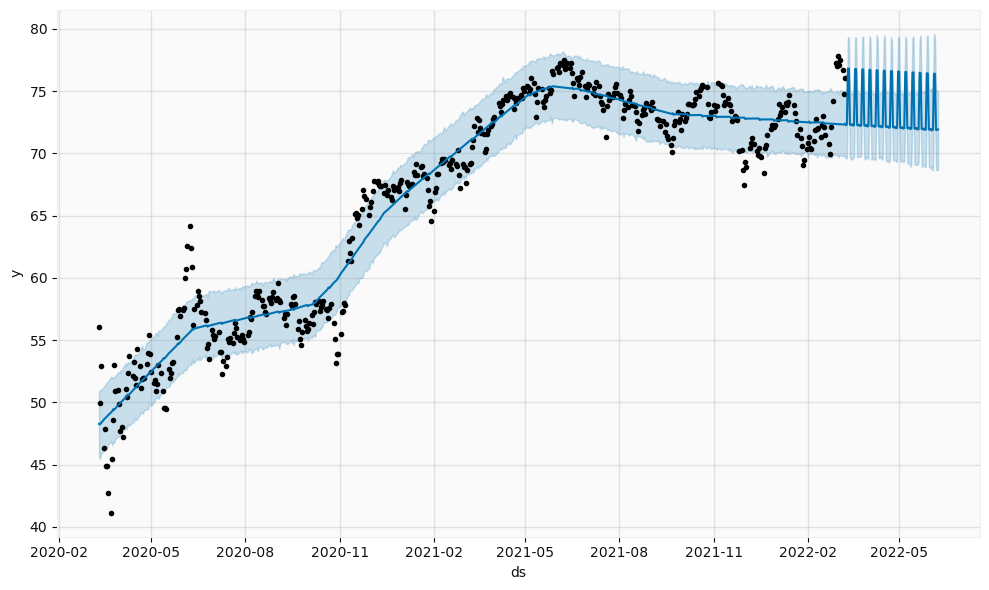

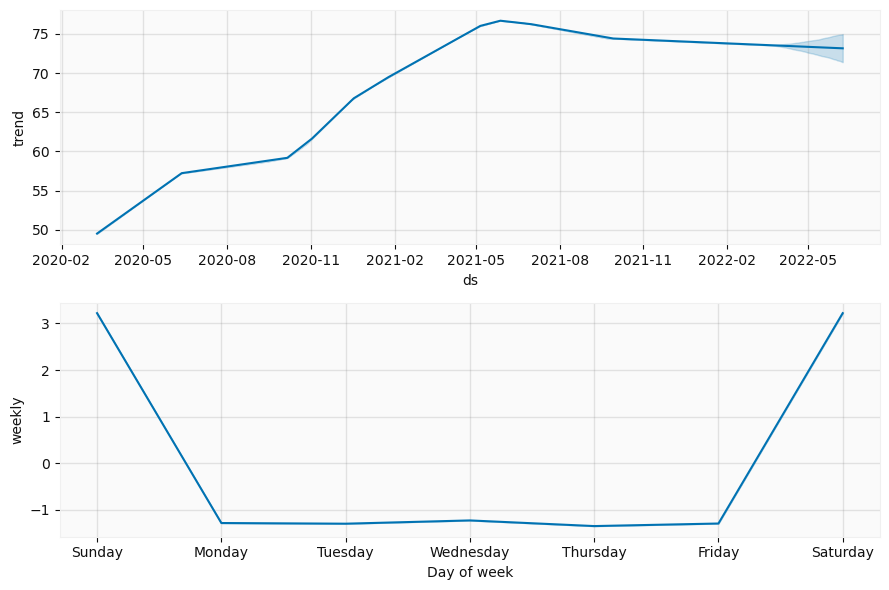

In [30]:
from prophet import Prophet
m = Prophet() #Create Prophet object
m.fit(df) #Fit Prophet model
future = m.make_future_dataframe(periods=90) #Create future dataframe
forecast = m.predict(future) #Predict future dataframe
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)